### Import Data

In [108]:
# paths
ROOT_DIR = "caverlee-2011/social_honeypot_icwsm_2011/"

In [130]:
# read data
import pandas as pd

ham_users = pd.read_csv(ROOT_DIR + "legitimate_users.txt",
                         sep='\t',
                         names = ['UserID',
                                  'CreatedAt',
                                  'CollectedAt',
                                  'NumberOfFollowings',
                                  'NumberOfFollowers',
                                  'NumberOfTweets',
                                  'LengthOfScreenName',
                                  'LengthOfDescriptionInUserProfile'])
ham_tweets = pd.read_csv(ROOT_DIR + "legitimate_users_tweets.txt",
                        sep='\t',
                        names = ['UserID',
                                'TweetID',
                                'Tweet',
                                'CreatedAt'],
                        quoting=3)

ham_followings = pd.read_csv(ROOT_DIR + "legitimate_users_followings.txt",
                             sep='\t',
                             names = ['UserID',
                                      'SeriesOfNumberOfFollowings'])


spam_users = pd.read_csv(ROOT_DIR + "content_polluters.txt",
                         sep='\t',
                         names = ['UserID',
                                  'CreatedAt',
                                  'CollectedAt',
                                  'NumberOfFollowings',
                                  'NumberOfFollowers',
                                  'NumberOfTweets',
                                  'LengthOfScreenName',
                                  'LengthOfDescriptionInUserProfile'])
spam_tweets = pd.read_csv(ROOT_DIR + "content_polluters_tweets.txt",
                          sep='\t',
                          names = ['UserID',
                                   'TweetID',
                                   'Tweet',
                                   'CreatedAt'],
                         quoting=3)
spam_followings = pd.read_csv(ROOT_DIR + "content_polluters_followings.txt",
                              sep='\t',
                              names = ['UserID',
                                       'SeriesOfNumberOfFollowings'])
       

In [110]:
# Debugging
# display(ham_users)
# display(ham_tweets)
# display(ham_followings)
# display(spam_users)
# display(spam_tweets)
# display(spam_followings)

### Feature Extraction

Features:

(User demographics)
1. Length of Screen Name (given)
2. Length of Description (given)
3. Longevity (calculate)

(User Friendship Networks)
1. Number of following (given)
2. Number of followers (given)
3. Ratio of Number of following and followers (calculate)
4. Percentage of Bidirectional Friends (missing)
5. Standard Deviation of Unique numerical IDs of following (missing)
6. standard deviation of unique numerical IDs of followers (missing)

(User Content)
1. the number of posted tweets (given)
2. number of posted tweets per day (calculate)
3. |links|in tweets /|tweets| (calculate)
4. |unique links|in tweets /|tweets| (calculate)
5. |@username|in tweets /|tweets| (calculate)
6. |unique@username|in tweets /|tweets| (calculate)
7. Average Content Similarity over all pairs of tweets posted by a user (missing, don't know similarity metric)
8. ZIP compression ratio of posted tweets (calculate)

(User History)
1. Change rate of number of following (calculate)

#### Given Features
Length of Screen Name, Length of User Profile Description, Number of Following, Number of Followers, Number of Tweets

In [131]:
import numpy as np
# given features
ham_users_input = ham_users[['UserID',
                             'LengthOfScreenName',
                            'LengthOfDescriptionInUserProfile',
                           'NumberOfFollowings',
                           'NumberOfFollowers',
                           'NumberOfTweets']]

spam_users_input = spam_users[['UserID',
                             'LengthOfScreenName',
                            'LengthOfDescriptionInUserProfile',
                           'NumberOfFollowings',
                           'NumberOfFollowers',
                           'NumberOfTweets']]

Extract number of Tweets recorded in the database per user. This will come in handy for calculations later down the line.

In [132]:
# get tweet counts by user
ham_tweet_counts = ham_tweets.groupby('UserID').size().reset_index()
ham_tweet_counts.columns = ['UserID','RecordedTweetCount']
ham_users = pd.merge(ham_users, ham_tweet_counts, on='UserID', how='left')

spam_tweet_counts = spam_tweets.groupby('UserID').size().reset_index()
spam_tweet_counts.columns = ['UserID','RecordedTweetCount']
spam_users = pd.merge(spam_users, spam_tweet_counts, on='UserID', how='left')

#### Longevity

In [133]:
# add longevity
from datetime import datetime
date_format = '%Y-%m-%d %H:%M:%S'

def get_longevity(start,end):
    start_date = datetime.strptime(start, date_format)
    end_date = datetime.strptime(end, date_format)
    return (end_date - start_date).days

ham_users_input['Longevity'] = ham_users.apply(lambda row: get_longevity(row['CreatedAt'],row['CollectedAt']), axis=1)

spam_users_input['Longevity'] = spam_users.apply(lambda row: get_longevity(row['CreatedAt'],row['CollectedAt']), axis=1)

#### Ratio of Following to Followers

In [134]:
# add ratio of followings to followers
ham_users_input['FollowRatio'] = ham_users_input['NumberOfFollowings'] / ham_users_input['NumberOfFollowers']
# replace divide by zero errors with 0
ham_users_input['FollowRatio'] = ham_users_input['FollowRatio'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add ratio of followings to followers
spam_users_input['FollowRatio'] = spam_users_input['NumberOfFollowings'] / spam_users_input['NumberOfFollowers']
# replace divide by zero errors with 0
spam_users_input['FollowRatio'] = spam_users_input['FollowRatio'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Tweets Posted Per Day

In [135]:
# add number of posted tweets per day
ham_users_input['TweetsPerDay'] = ham_users_input['NumberOfTweets'] / ham_users_input['Longevity']
# replace divide by zero errors with 0
ham_users_input['TweetsPerDay'] = ham_users_input['TweetsPerDay'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add number of posted tweets per day
spam_users_input['TweetsPerDay'] = spam_users_input['NumberOfTweets'] / spam_users_input['Longevity']
# replace divide by zero errors with 0
spam_users_input['TweetsPerDay'] = spam_users_input['TweetsPerDay'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Average Links Per Tweet

In [136]:
# add average links per tweet
import re

# function for counting number of links in tweet
def count_links(text):
    return len(re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', str(text)))

# add link count to tweets dataframe
ham_tweets['LinkCount'] = ham_tweets['Tweet'].apply(lambda x: count_links(x))
# get sum of links by user
ham_sum_links = ham_tweets.groupby('UserID')['LinkCount'].sum().reset_index()
ham_sum_links.columns = ['UserID','LinkSum']
# add link average to features
ham_users_input['LinkAverage'] = ham_sum_links['LinkSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['LinkAverage'] = ham_users_input['LinkAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add link count to tweets dataframe
spam_tweets['LinkCount'] = spam_tweets['Tweet'].apply(lambda x: count_links(x))
# get sum of links by user
spam_sum_links = spam_tweets.groupby('UserID')['LinkCount'].sum().reset_index()
spam_sum_links.columns = ['UserID','LinkSum']
# add link average to features
spam_users_input['LinkAverage'] = spam_sum_links['LinkSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['LinkAverage'] = spam_users_input['LinkAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Average Unique Links Per Tweet

In [137]:
# add average unique links per tweet

# function for finding links in tweet
def get_links(text):
    return set(re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', str(text)))

# function for merging sets
def merge_sets(sets):
    return set.union(*sets)

# add unique links to tweets dataframe
ham_tweets['UniqueLinks'] = ham_tweets['Tweet'].apply(lambda x: get_links(x))
# get unique links by user
ham_unique_links = ham_tweets.groupby('UserID')['UniqueLinks'].agg(merge_sets).reset_index()
ham_unique_links.columns = ['UserID','UniqueLinks']
ham_unique_links['UniqueLinkSum'] = ham_unique_links['UniqueLinks'].apply(lambda x: len(x))
# add unique link average to features
ham_users_input['UniqueLinkAverage'] = ham_unique_links['UniqueLinkSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['UniqueLinkAverage'] = ham_users_input['UniqueLinkAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add unique links to tweets dataframe
spam_tweets['UniqueLinks'] = spam_tweets['Tweet'].apply(lambda x: get_links(x))
# get unique links by user
spam_unique_links = spam_tweets.groupby('UserID')['UniqueLinks'].agg(merge_sets).reset_index()
spam_unique_links.columns = ['UserID','UniqueLinks']
spam_unique_links['UniqueLinkSum'] = spam_unique_links['UniqueLinks'].apply(lambda x: len(x))
# add unique link average to features
spam_users_input['UniqueLinkAverage'] = spam_unique_links['UniqueLinkSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['UniqueLinkAverage'] = spam_users_input['UniqueLinkAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Average Mentions Per Tweet

In [138]:
# add average mentions per tweet

def count_mentions(text):
    return len(re.findall("@([a-zA-Z0-9]{1,15})", str(text)))

# add username count to tweets dataframe
ham_tweets['MentionCount'] = ham_tweets['Tweet'].apply(lambda x: count_mentions(x))
# get sum of mentions by user
ham_sum_mentions = ham_tweets.groupby('UserID')['MentionCount'].sum().reset_index()
ham_sum_mentions.columns = ['UserID','MentionSum']
# add mention average to features
ham_users_input['MentionAverage'] = ham_sum_mentions['MentionSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['MentionAverage'] = ham_users_input['MentionAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add username count to tweets dataframe
spam_tweets['MentionCount'] = spam_tweets['Tweet'].apply(lambda x: count_mentions(x))
# get sum of mentions by user
spam_sum_mentions = spam_tweets.groupby('UserID')['MentionCount'].sum().reset_index()
spam_sum_mentions.columns = ['UserID','MentionSum']
# add mention average to features
spam_users_input['MentionAverage'] = spam_sum_mentions['MentionSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['MentionAverage'] = spam_users_input['MentionAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Average Unique Mentions Per Tweet

In [139]:
# add average unique mentions per tweet

# function for finding mentions in tweet
def get_mentions(text):
    return set(re.findall("@([a-zA-Z0-9]{1,15})", str(text)))

# add unique mentions to tweets dataframe
ham_tweets['UniqueMentions'] = ham_tweets['Tweet'].apply(lambda x: get_mentions(x))
# get unique mentions by user
ham_unique_mentions = ham_tweets.groupby('UserID')['UniqueMentions'].agg(merge_sets).reset_index()
ham_unique_mentions.columns = ['UserID','UniqueMentions']
ham_unique_mentions['UniqueMentionSum'] = ham_unique_mentions['UniqueMentions'].apply(lambda x: len(x))
# add unique mention average to features
ham_users_input['UniqueMentionAverage'] = ham_unique_mentions['UniqueMentionSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['UniqueMentionAverage'] = ham_users_input['UniqueMentionAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add unique mentions to tweets dataframe
spam_tweets['UniqueMentions'] = spam_tweets['Tweet'].apply(lambda x: get_mentions(x))
# get unique mentions by user
spam_unique_mentions = spam_tweets.groupby('UserID')['UniqueMentions'].agg(merge_sets).reset_index()
spam_unique_mentions.columns = ['UserID','UniqueMentions']
spam_unique_mentions['UniqueMentionSum'] = spam_unique_mentions['UniqueMentions'].apply(lambda x: len(x))
# add unique mention average to features
spam_users_input['UniqueMentionAverage'] = spam_unique_mentions['UniqueMentionSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['UniqueMentionAverage'] = spam_users_input['UniqueMentionAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [140]:
display(ham_unique_mentions)

,UserID,UniqueMentions,UniqueMentionSum
0,614,"{sdlatham, markjaquith, ryanwoodings, themanda...",62
1,1038,"{LiavanBekhoven, tivoliutrecht, lrs, mroumen, ...",92
2,1437,"{OPGear, andylolz, cassandra, johnfayman, ryan...",41
3,2615,"{tarintowers, bocome, TrekLightGear, mrwarren,...",43
4,3148,"{webupd8, dregar, avianto, designfeed, cristia...",97
...,...,...,...
19266,93390990,{},0
19267,93402679,{},0
19268,93419256,{},0
19269,93426370,{},0


#### Zip Compression Ratio

In [141]:
# add zip compression ratio

import zlib

# get compression ratio of tweets
def get_compression_ratio(text):
    data=text.encode('utf-8')
    compressed_data = zlib.compress(data)
    return len(data)/len(compressed_data)

# concatenate tweets by user
ham_concat_tweets = ham_tweets.groupby('UserID')['Tweet'].agg(lambda x: ' '.join(str(x))).reset_index()
ham_concat_tweets.columns = ['UserID','Concat_Tweets']
# calculate compression ratio from concatenated tweets
ham_concat_tweets['Compression_Ratio'] = ham_concat_tweets['Concat_Tweets'].apply(lambda x: get_compression_ratio(x))
# add to features
ham_users_input = pd.merge(ham_users_input, ham_concat_tweets[['UserID','Compression_Ratio']], on='UserID', how='left')
# give users with no tweets compression ratio of 0
ham_users_input['Compression_Ratio'] = ham_users_input['Compression_Ratio'].fillna(0)

# concatenate tweets by user
spam_concat_tweets = spam_tweets.groupby('UserID')['Tweet'].agg(lambda x: ' '.join(str(x))).reset_index()
spam_concat_tweets.columns = ['UserID','Concat_Tweets']
# calculate compression ratio from concatenated tweets
spam_concat_tweets['Compression_Ratio'] = spam_concat_tweets['Concat_Tweets'].apply(lambda x: get_compression_ratio(x))
# add to features
spam_users_input = pd.merge(spam_users_input, spam_concat_tweets[['UserID','Compression_Ratio']], on='UserID', how='left')
# give users with no tweets compression ratio of 0
spam_users_input['Compression_Ratio'] = spam_users_input['Compression_Ratio'].fillna(0)

#### Following Change Rate

In [142]:
# add following change rate
import math

# calculate change rate based on sequence string
def calculate_change_rate(seq_str):
    seq = [int(x) for x in seq_str.split(",")]
    n = len(seq)
    # perform summation
    total =0
    for i in range(0,n-1):
        total += seq[i+1] - seq[i]
    return total/(n-1)
#     return math.sqrt(total/(n-1))

# calculate following change rate by user
ham_followings['FollowingChangeRate'] = ham_followings['SeriesOfNumberOfFollowings'].apply(lambda x: calculate_change_rate(x))
# add to features
ham_users_input = pd.merge(ham_users_input, ham_followings[['UserID','FollowingChangeRate']], on='UserID', how='left')
# fill in zeroes
ham_users_input['FollowingChangeRate'] = ham_users_input['FollowingChangeRate'].fillna(0)

# calculate following change rate by user
spam_followings['FollowingChangeRate'] = spam_followings['SeriesOfNumberOfFollowings'].apply(lambda x: calculate_change_rate(x))
# add to features
spam_users_input = pd.merge(spam_users_input, spam_followings[['UserID','FollowingChangeRate']], on='UserID', how='left')
# fill in zeroes
spam_users_input['FollowingChangeRate'] = spam_users_input['FollowingChangeRate'].fillna(0)

### Get Hashtags

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [151]:
import re

def extract_hashtags(tweet):
    return re.findall(r'#([A-Za-z][A-Za-z0-9]*)', str(tweet))

spam_tweets['Hashtags'] = spam_tweets['Tweet'].apply(lambda x: extract_hashtags(x))
spam_tweets['HashtagCount'] = spam_tweets['Tweet'].apply(lambda x: len(extract_hashtags(x)))
spam_tweets['UniqueHashtags'] = spam_tweets['Tweet'].apply(lambda x: set(extract_hashtags(x)))
ham_tweets['Hashtags'] = ham_tweets['Tweet'].apply(lambda x: extract_hashtags(x))
ham_tweets['HashtagCount'] = ham_tweets['Tweet'].apply(lambda x: len(set(extract_hashtags(x))))
ham_tweets['UniqueHashtags'] = ham_tweets['Tweet'].apply(lambda x: set(extract_hashtags(x)))
display(spam_tweets.sort_values(by='HashtagCount', ascending=False))

,UserID,TweetID,Tweet,CreatedAt,LinkCount,UniqueLinks,MentionCount,UniqueMentions,Hashtags,HashtagCount,UniqueHashtags
608682,40130106,17661910652,#ger#ger#ger#ger#ger#ger#ger#ger#ger#ger#ger#g...,2010-07-03 11:34:48,0,{},0,{},"[ger, ger, ger, ger, ger, ger, ger, ger, ger, ...",35,{ger}
608730,40130106,17962660794,#ger#ger#ger#ger#ger#ger#ger#ger#ger#ger#ger#g...,2010-07-07 11:46:02,0,{},0,{},"[ger, ger, ger, ger, ger, ger, ger, ger, ger, ...",35,{ger}
832413,57608714,16066163685,#GER #GER #GER #GER #GER #GER #GER #GER #GER #...,2010-06-13 06:37:36,0,{},0,{},"[GER, GER, GER, GER, GER, GER, GER, GER, GER, ...",28,{GER}
805344,55710866,17036228925,#esp #esp #esp #esp #esp #esp #esp #esp #esp #...,2010-06-25 13:55:10,0,{},0,{},"[esp, esp, esp, esp, esp, esp, esp, esp, esp, ...",28,{esp}
832466,57608714,16871354466,#GER #GER #GER #GER #GER #GER #GER #GER #GER #...,2010-06-23 14:24:11,0,{},0,{},"[GER, GER, GER, GER, GER, GER, GER, GER, GER, ...",27,{GER}
...,...,...,...,...,...,...,...,...,...,...,...
827555,57246997,5755743971,New Blog Post: Get A Payday Loan Today http://...,2009-11-15 21:52:23,1,{http://tinyurl.com},0,{},[],0,{}
827554,57246997,5755679468,New Blog Post: Why Get A Same Day Payday Loan?...,2009-11-15 21:49:28,1,{http://tinyurl.com},0,{},[],0,{}
827553,57246997,5755633816,New Blog Post: A Faxless Payday Loan Is Fast A...,2009-11-15 21:47:20,1,{http://tinyurl.com},0,{},[],0,{}
827552,57246997,5704853971,Don't miss the chance to win $500 per week by ...,2009-11-14 02:16:17,1,{http://tinyurl.com},0,{},[],0,{}


In [152]:
# Grouping by 'UserID' and counting tweets with at least one hashtag
ham_hashtag_count = ham_tweets.groupby('UserID')['HashtagCount'].apply(lambda x: (x > 0).sum()).reset_index()
ham_hashtag_count.columns = ['UserID', 'TweetsWithHashtagsCount']
ham_hashtag_count['TweetsWithHashtagsCount'] = ham_hashtag_count['TweetsWithHashtagsCount'].astype(int)

ham_users_input['HashtagTweetsCount'] = ham_hashtag_count['TweetsWithHashtagsCount']
ham_users_input['HashtagTweetsCount'] = ham_users_input['HashtagTweetsCount'].replace([np.inf, -np.inf], np.nan).fillna(0)

spam_hashtag_count = spam_tweets.groupby('UserID')['HashtagCount'].apply(lambda x: (x > 0).sum()).reset_index()
spam_hashtag_count.columns = ['UserID', 'TweetsWithHashtagsCount']
spam_hashtag_count['TweetsWithHashtagsCount'] = spam_hashtag_count['TweetsWithHashtagsCount'].astype(int)

spam_users_input['HashtagTweetsCount'] = spam_hashtag_count['TweetsWithHashtagsCount']
spam_users_input['HashtagTweetsCount'] = spam_users_input['HashtagTweetsCount'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [160]:
ham_sum_hashtags = ham_tweets.groupby('UserID')['HashtagCount'].sum().reset_index()
ham_sum_hashtags.columns = ['UserID','HashtagSum']
# add mention average to features
ham_users_input['HashtagAverage'] = ham_sum_hashtags['HashtagSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['HashtagAverage'] = ham_users_input['HashtagAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

ham_unique_hashtags = ham_tweets.groupby('UserID')['UniqueHashtags'].agg(merge_sets).reset_index()
ham_unique_hashtags.columns = ['UserID','UniqueHashtags']
ham_unique_hashtags['UniqueHashtagSum'] = ham_unique_hashtags['UniqueHashtags'].apply(lambda x: len(x))
# add unique mention average to features
ham_users_input['UniqueHashtagAverage'] = ham_unique_hashtags['UniqueHashtagSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['UniqueHashtagAverage'] = ham_users_input['UniqueHashtagAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [228]:
spam_sum_hashtags = spam_tweets.groupby('UserID')['HashtagCount'].sum().reset_index()
spam_sum_hashtags.columns = ['UserID','HashtagSum']
# add mention average to features
spam_users_input['HashtagAverage'] = spam_sum_hashtags['HashtagSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['HashtagAverage'] = spam_users_input['HashtagAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

spam_unique_hashtags = spam_tweets.groupby('UserID')['UniqueHashtags'].agg(merge_sets).reset_index()
spam_unique_hashtags.columns = ['UserID','UniqueHashtags']
spam_unique_hashtags['UniqueHashtagSum'] = spam_unique_hashtags['UniqueHashtags'].apply(lambda x: len(x))
# add unique mention average to features
spam_users_input['UniqueHashtagAverage'] = spam_unique_hashtags['UniqueHashtagSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['UniqueHashtagAverage'] = spam_users_input['UniqueHashtagAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [162]:
display(spam_users_input)

,UserID,LengthOfScreenName,LengthOfDescriptionInUserProfile,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,Longevity,FollowRatio,TweetsPerDay,LinkAverage,UniqueLinkAverage,MentionAverage,UniqueMentionAverage,Compression_Ratio,FollowingChangeRate,label,HashtagTweetsCount,HashtagAverage,UniqueHashtagAverage
0,6301,8,132,3269,3071,861,1217,1.064474,0.707477,0.705000,0.125000,0.335000,0.220000,2.906114,2.724891,1,8.0,0.090000,0.065000
1,10836,9,134,1949,793,226,1329,2.457755,0.170053,0.656566,0.185000,0.272727,0.065657,3.439276,-0.021834,1,64.0,0.510101,0.030303
2,10997,12,158,1119,9644,38674,1272,0.116031,30.404088,0.269036,0.065000,0.553299,0.253807,2.672691,10.737991,1,33.0,0.659898,0.538071
3,633293,11,121,2174,6029,12718,1105,0.360590,11.509502,0.320000,0.085000,0.445000,0.250000,2.609804,6.069869,1,18.0,0.095000,0.090000
4,717883,6,70,7731,7029,873,1105,1.099872,0.790045,0.690000,0.045226,0.105000,0.025000,2.630435,0.807860,1,2.0,0.010000,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22218,173715049,12,0,63,10,29,0,6.300000,0.000000,0.000000,0.000000,0.000000,0.000000,6.968932,48.333333,1,0.0,0.000000,0.000000
22219,173718053,8,0,83,10,35,0,8.300000,0.000000,0.000000,0.000000,0.000000,0.000000,7.201667,37.000000,1,0.0,0.000000,0.000000
22220,173721018,13,0,67,9,21,0,7.444444,0.000000,0.000000,0.000000,0.000000,0.000000,5.387629,42.000000,1,0.0,0.000000,0.000000
22221,173723395,12,0,35,4,17,0,8.750000,0.000000,0.000000,0.000000,0.000000,0.000000,5.145278,45.666667,1,0.0,0.000000,0.000000


#### Total Number of Hashtags

In [23]:
spam_counts = spam_tweets['HashtagCount'].value_counts(normalize=True)
spam_cumsum = spam_counts.cumsum() * 100
spam_cumsum = spam_cumsum[spam_cumsum.index <= 10]

ham_counts = ham_tweets['HashtagCount'].value_counts(normalize=True)
ham_cumsum = ham_counts.cumsum() * 100
ham_cumsum = ham_cumsum[ham_cumsum.index <= 10]

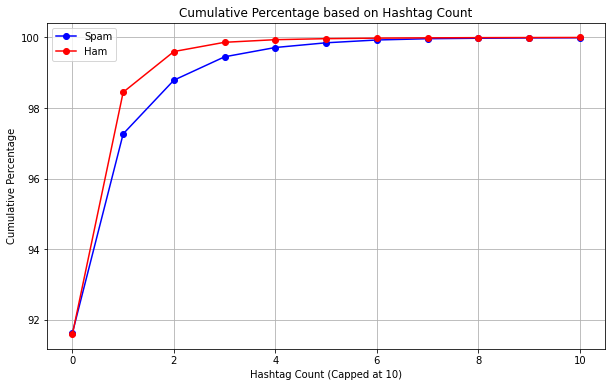

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(spam_cumsum.index, spam_cumsum.values, marker='o', linestyle='-', color='blue', label='Spam')
plt.plot(ham_cumsum.index, ham_cumsum.values, marker='o', linestyle='-', color='red', label='Ham')
plt.xlabel('Hashtag Count (Capped at 10)')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Percentage based on Hashtag Count')
plt.grid(True)
plt.legend()
plt.show()

#### Number of Unique Hashtags

In [27]:
spam_ucounts = spam_tweets['UniqueHashtagCount'].value_counts(normalize=True)
spam_ucumsum = spam_ucounts.cumsum() * 100
spam_ucumsum = spam_ucumsum[spam_ucumsum.index <= 10]

ham_ucounts = ham_tweets['UniqueHashtagCount'].value_counts(normalize=True)
ham_ucumsum = ham_ucounts.cumsum() * 100
ham_ucumsum = ham_ucumsum[ham_ucumsum.index <= 10]

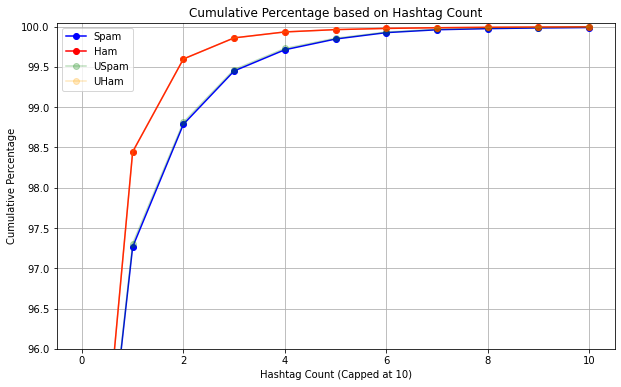

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(spam_cumsum.index, spam_cumsum.values, marker='o', linestyle='-', color='blue', label='Spam')
plt.plot(ham_cumsum.index, ham_cumsum.values, marker='o', linestyle='-', color='red', label='Ham')
plt.plot(spam_ucumsum.index, spam_ucumsum.values, marker='o', linestyle='-', color='green', alpha=0.25, label='USpam')
plt.plot(ham_ucumsum.index, ham_ucumsum.values, marker='o', linestyle='-', color='orange', alpha=0.25, label='UHam')
plt.xlabel('Hashtag Count (Capped at 10)')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Percentage based on Hashtag Count')
plt.ylim(96, 100.05)
plt.grid(True)
plt.legend()
plt.show()

#### Number of Words in Hashtag

In [178]:
import wordsegment
from wordsegment import load, segment

# Assuming 'ham_tweets' is your DataFrame

# Initialize 'AverageWordsInHashtag' column with zeros
ham_tweets['AverageWordsInHashtag'] = 0

# Load wordsegment
load()

# Calculate average words in hashtag for rows with at least one hashtag
hashtag_rows = ham_tweets[ham_tweets['HashtagCount'] > 0]
hashtag_rows['AverageWordsInHashtag'] = hashtag_rows['Hashtags'].apply(
    lambda hashtags: sum(len(segment(hashtag)) for hashtag in hashtags) / len(hashtags)
)

# Update 'AverageWordsInHashtag' column in the original DataFrame
ham_tweets.update(hashtag_rows)

# Display the updated DataFrame
display(ham_tweets)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,UserID,TweetID,Tweet,CreatedAt,LinkCount,UniqueLinks,MentionCount,UniqueMentions,Hashtags,HashtagCount,UniqueHashtags,AverageWordsInHashtag
0,614.0,5.912305e+09,… at house party in Daybreak. Not as weird as ...,2009-11-20 23:52:52,0.0,{},0.0,{},[],0.0,{},0.0
1,614.0,5.908467e+09,Taxiing — at SLC Salt Lake City International...,2009-11-20 20:42:48,1.0,{http://gowal.la},0.0,{},[],0.0,{},0.0
2,614.0,5.904902e+09,Almost home! — at PDX Portland International ...,2009-11-20 18:11:01,1.0,{http://gowal.la},0.0,{},[],0.0,{},0.0
3,614.0,5.900352e+09,Lunch! — at Ten01 http://gowal.la/s/Awa,2009-11-20 15:04:42,1.0,{http://gowal.la},0.0,{},[],0.0,{},0.0
4,614.0,5.900313e+09,Mm … books — at @Powells http://gowal.la/s/6fe,2009-11-20 15:03:06,1.0,{http://gowal.la},1.0,{Powells},[],0.0,{},0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3259688,93390990.0,6.168916e+09,meet me on ELIMINATE pro!!,2009-11-29 06:44:03,0.0,{},0.0,{},[],0.0,{},0.0
3259689,93402679.0,6.170059e+09,my twitter,2009-11-29 07:52:22,0.0,{},0.0,{},[],0.0,{},0.0
3259690,93419256.0,6.171947e+09,exploring this thing...,2009-11-29 09:25:53,0.0,{},0.0,{},[],0.0,{},0.0
3259691,93426370.0,6.172856e+09,"learning the rap ice ice baby LOL, not very gd...",2009-11-29 10:08:09,0.0,{},0.0,{},[],0.0,{},0.0


In [183]:
spam_tweets['AverageWordsInHashtag'] = 0
load()
hashtag_rows = spam_tweets[spam_tweets['HashtagCount'] > 0]
hashtag_rows['AverageWordsInHashtag'] = hashtag_rows['Hashtags'].apply(
    lambda hashtags: sum(len(segment(hashtag)) for hashtag in hashtags) / len(hashtags)
)

spam_tweets.update(hashtag_rows)
display(spam_tweets)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,UserID,TweetID,Tweet,CreatedAt,LinkCount,UniqueLinks,MentionCount,UniqueMentions,Hashtags,HashtagCount,UniqueHashtags,AverageWordsInHashtag
0,6301.0,5.599520e+09,MELBOURNE ENQUIRY: Seeking a variety of acts f...,2009-11-10 15:14:31,1.0,{http://bit.ly},0.0,{},[],0.0,{},0.0
1,6301.0,5.600314e+09,THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...,2009-11-10 15:46:05,2.0,"{http://bbootcampsyd.eventbrite.com, http://bi...",0.0,{},[],0.0,{},0.0
2,6301.0,5.600329e+09,THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...,2009-11-10 15:46:40,2.0,"{http://bbootcampsyd.eventbrite.com, http://bi...",0.0,{},[],0.0,{},0.0
3,6301.0,5.600338e+09,THE BURLESQUE BOOTCAMP SYDNEY - Open Date tick...,2009-11-10 15:47:03,2.0,"{http://fb.me, http://bbootcampsyd.eventbrite....",0.0,{},[],0.0,{},0.0
4,6301.0,5.600565e+09,"Come to ""The Burlesque Bootcamp - Sydney"" Satu...",2009-11-10 15:56:03,1.0,{http://bit.ly},0.0,{},[],0.0,{},0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2353468,173723395.0,2.012195e+10,1000 twitter followers: http://bit.ly/s3oi?=Xg...,2010-08-02 02:20:49,1.0,{http://bit.ly},5.0,"{ZaYIAm, Ricki, GEMiNi, syahrulmoe, hnybfly}",[],0.0,{},0.0
2353469,173723395.0,2.012209e+10,2000 new visitors to your blog: http://bit.ly/...,2010-08-02 02:24:23,1.0,{http://bit.ly},4.0,"{vanessasuzuki, AinaXtremepro, tomekami, pytda}",[],0.0,{},0.0
2353470,173723395.0,2.012244e+10,1000s twitter followers: http://bit.ly/s3oi?=r...,2010-08-02 02:33:11,1.0,{http://bit.ly},5.0,"{SH0EHEAd, ecavisiah, lenilukitasari, ZombieTh...",[],0.0,{},0.0
2353471,173723395.0,2.012257e+10,How 2 create fabulous blog topics: http://bit....,2010-08-02 02:36:40,1.0,{http://bit.ly},0.0,{},[],0.0,{},0.0


In [202]:
average_words_ham_group = ham_tweets.groupby('UserID')['AverageWordsInHashtag'].sum().reset_index()
ham_users_input['AverageWordsInHashtag'] = average_words_ham_group['AverageWordsInHashtag'] / ham_users_input['HashtagTweetsCount']
ham_users_input['AverageWordsInHashtag'] = ham_users_input['AverageWordsInHashtag'].replace([np.inf, -np.inf], np.nan).fillna(0)

average_words_spam_group = spam_tweets.groupby('UserID')['AverageWordsInHashtag'].sum().reset_index()
spam_users_input['AverageWordsInHashtag'] = average_words_spam_group['AverageWordsInHashtag'] / spam_users_input['HashtagTweetsCount']
spam_users_input['AverageWordsInHashtag'] = spam_users_input['AverageWordsInHashtag'].replace([np.inf, -np.inf], np.nan).fillna(0)

# display(spam_tweets.sort_values('AverageWordsInHashtag', ascending=False))

,UserID,LengthOfScreenName,LengthOfDescriptionInUserProfile,NumberOfFollowings,NumberOfFollowers,NumberOfTweets,Longevity,FollowRatio,TweetsPerDay,LinkAverage,UniqueLinkAverage,MentionAverage,UniqueMentionAverage,Compression_Ratio,FollowingChangeRate,label,HashtagTweetsCount,HashtagAverage,UniqueHashtagAverage,AverageWordsInHashtag
0,6301,8,132,3269,3071,861,1217,1.064474,0.707477,0.705000,0.125000,0.335000,0.220000,2.906114,2.724891,1,8.0,0.090000,0.065000,1.187500
1,10836,9,134,1949,793,226,1329,2.457755,0.170053,0.656566,0.185000,0.272727,0.065657,3.439276,-0.021834,1,64.0,0.510101,0.030303,1.945312
2,10997,12,158,1119,9644,38674,1272,0.116031,30.404088,0.269036,0.065000,0.553299,0.253807,2.672691,10.737991,1,33.0,0.659898,0.538071,1.877658
3,633293,11,121,2174,6029,12718,1105,0.360590,11.509502,0.320000,0.085000,0.445000,0.250000,2.609804,6.069869,1,18.0,0.095000,0.090000,2.083333
4,717883,6,70,7731,7029,873,1105,1.099872,0.790045,0.690000,0.045226,0.105000,0.025000,2.630435,0.807860,1,2.0,0.010000,0.010000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22218,173715049,12,0,63,10,29,0,6.300000,0.000000,0.000000,0.000000,0.000000,0.000000,6.968932,48.333333,1,0.0,0.000000,0.000000,0.000000
22219,173718053,8,0,83,10,35,0,8.300000,0.000000,0.000000,0.000000,0.000000,0.000000,7.201667,37.000000,1,0.0,0.000000,0.000000,0.000000
22220,173721018,13,0,67,9,21,0,7.444444,0.000000,0.000000,0.000000,0.000000,0.000000,5.387629,42.000000,1,0.0,0.000000,0.000000,0.000000
22221,173723395,12,0,35,4,17,0,8.750000,0.000000,0.000000,0.000000,0.000000,0.000000,5.145278,45.666667,1,0.0,0.000000,0.000000,0.000000


In [182]:
# Fun little find, this gotta be one of the most 2009 things I've ever read
print(ham_tweets.iloc[2071078]['Tweet'])

RT @BigEazy17: #ifyoucanreadthistweetyouhavebeenontwittertoofuckinlongbutdontworryyouarenotalonelikemichaeljackson


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,UserID,TweetID,Tweet,CreatedAt,LinkCount,UniqueLinks,MentionCount,UniqueMentions,Hashtags,HashtagCount,UniqueHashtags,AverageWordsInHashtag,Bins
0,614.0,5.912305e+09,… at house party in Daybreak. Not as weird as ...,2009-11-20 23:52:52,0.0,{},0.0,{},[],0.0,{},0.0,"[-0.1, 1.0)"
1,614.0,5.908467e+09,Taxiing — at SLC Salt Lake City International...,2009-11-20 20:42:48,1.0,{http://gowal.la},0.0,{},[],0.0,{},0.0,"[-0.1, 1.0)"
2,614.0,5.904902e+09,Almost home! — at PDX Portland International ...,2009-11-20 18:11:01,1.0,{http://gowal.la},0.0,{},[],0.0,{},0.0,"[-0.1, 1.0)"
3,614.0,5.900352e+09,Lunch! — at Ten01 http://gowal.la/s/Awa,2009-11-20 15:04:42,1.0,{http://gowal.la},0.0,{},[],0.0,{},0.0,"[-0.1, 1.0)"
4,614.0,5.900313e+09,Mm … books — at @Powells http://gowal.la/s/6fe,2009-11-20 15:03:06,1.0,{http://gowal.la},1.0,{Powells},[],0.0,{},0.0,"[-0.1, 1.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259688,93390990.0,6.168916e+09,meet me on ELIMINATE pro!!,2009-11-29 06:44:03,0.0,{},0.0,{},[],0.0,{},0.0,"[-0.1, 1.0)"
3259689,93402679.0,6.170059e+09,my twitter,2009-11-29 07:52:22,0.0,{},0.0,{},[],0.0,{},0.0,"[-0.1, 1.0)"
3259690,93419256.0,6.171947e+09,exploring this thing...,2009-11-29 09:25:53,0.0,{},0.0,{},[],0.0,{},0.0,"[-0.1, 1.0)"
3259691,93426370.0,6.172856e+09,"learning the rap ice ice baby LOL, not very gd...",2009-11-29 10:08:09,0.0,{},0.0,{},[],0.0,{},0.0,"[-0.1, 1.0)"


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


[0.99, 2.0)     63.584047
[2.0, 3.0)      88.434458
[3.0, 4.0)      95.763707
[4.0, 5.0)      98.785491
[5.0, 6.0)      99.691416
[6.0, 7.0)      99.915101
[7.0, 8.0)      99.977123
[8.0, 9.0)      99.994408
[9.0, 10.0)    100.000000
Name: Bins, dtype: float64


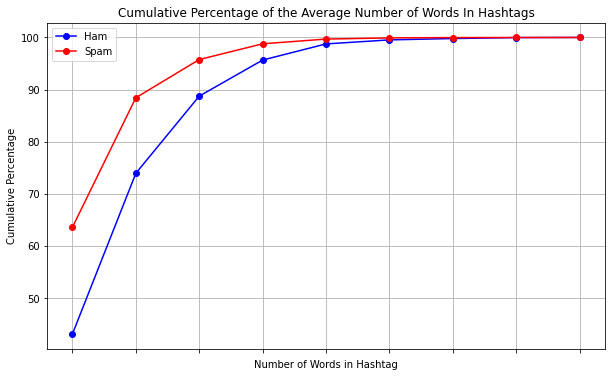

In [194]:
# Cumulative Sum of Average Number of Words in Hashtag, for visualization purposes

bin_edges = [0.99, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Adjust the bin edges as needed

# Use pd.cut() to create bins for 'AverageWordsInHashtag'
ham_tweets_whashtags = ham_tweets[ham_tweets['AverageWordsInHashtag'] > 0]
spam_tweets_whashtags = spam_tweets[spam_tweets['AverageWordsInHashtag'] > 0]
ham_tweets_whashtags['Bins'] = pd.cut(ham_tweets_whashtags['AverageWordsInHashtag'], bins=bin_edges, right=False)
spam_tweets_whashtags['Bins'] = pd.cut(spam_tweets_whashtags['AverageWordsInHashtag'], bins=bin_edges, right=False)

display(ham_tweets)

# Calculate cumulative percentage
ham_cumulative_percentages = (
    ham_tweets_whashtags['Bins']
    .value_counts(normalize=True)
    .sort_index()
    .cumsum()
    * 100  # Multiply by 100 to get percentages
)

spam_cumulative_percentages = (
    spam_tweets_whashtags['Bins']
    .value_counts(normalize=True)
    .sort_index()
    .cumsum()
    * 100  # Multiply by 100 to get percentages
)

print(spam_cumulative_percentages)

# spam_counts = spam_tweets['Bins'].value_counts(normalize=True)
# spam_cumsum = spam_counts.cumsum() * 100
# spam_cumsum = spam_cumsum[spam_cumsum.index <= 10]

# ham_counts = ham_tweets['Bins'].value_counts(normalize=True)
# ham_cumsum = ham_counts.cumsum() * 100
# ham_cumsum = ham_cumsum[ham_cumsum.index <= 10]

# Plot the cumulative percentage as a graph
plt.figure(figsize=(10, 6))
ham_cumulative_percentages.plot(kind='line', marker='o', color='blue', label='Ham')
spam_cumulative_percentages.plot(kind='line', marker='o', color='red', label='Spam')
plt.xlabel('Number of Words in Hashtag')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Percentage of the Average Number of Words In Hashtags')
plt.grid(True)
plt.legend()
plt.show()


### Data Preparation

In [241]:
# add labels
ham_users_input['label'] = 0 
spam_users_input['label'] = 1

In [231]:
ham_users_input_copy = ham_users_input.copy()
spam_users_input_copy = spam_users_input.copy()

In [239]:
ham_users_input = ham_users_input_copy.copy()
spam_users_input = spam_users_input_copy.copy()

In [232]:
ham_users_input = ham_users_input.drop(columns=['HashtagAverage'], errors='ignore')
spam_users_input = spam_users_input.drop(columns=['HashtagAverage'], errors='ignore')

In [243]:
# combine dataframes
df = pd.concat([ham_users_input,spam_users_input])
# drop userID
df.drop(['UserID'], axis=1, inplace=True)

In [244]:
# separate features from labels
X = df.drop('label', axis = 1)
y = df['label']

In [290]:
# split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Training Classifier

In [291]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# train RF
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

### Testing Classifer

In [292]:
# predict on test set
y_pred = clf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9542
